### King County - start urban farming club 

#### close to city and affordable houses with large lots

In [13]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

### background check on the region to pick the citys of intrest

In [4]:
us_cities = pd.read_csv('data/uscities.csv')

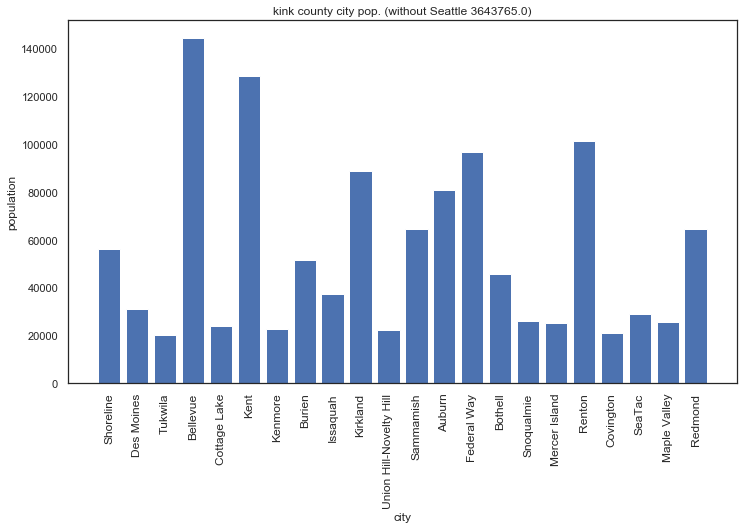

(22, 19)

In [28]:
c = us_cities[(us_cities.state_id == 'WA') & (us_cities.county_name == 'King')]
cns = c[(c.city != 'Seattle') & (c.population > 20000)]
plt.figure(figsize=(12,8))
plt.bar(cns.city,cns.population)
plt.xticks(cns.city, rotation='vertical', size=12)
plt.xlabel('city')
plt.ylabel('population')
plt.title(f'kink county city pop. (without Seattle {c.population.max()})')
plt.gcf().subplots_adjust(bottom=0.25)
plt.savefig('./pic_exports/CitySelect_Population_no_Seattle', dpi=300)
plt.show()
cns.shape

In [29]:
Selcted_cities = c[(c.population > 20000)]
Selcted_cities.shape
Selcted_cities.to_csv('data/King_county_city_data.csv')

### Load House price data and correlate to selected citys

In [82]:
df_raw = pd.read_csv('data/King_County_House_prices_dataset.csv')
city_data =  pd.read_csv('data/King_county_city_data.csv')

(-122.5658139784946, -121.6541860215054, 47.1223143598234, 47.814585640176595)

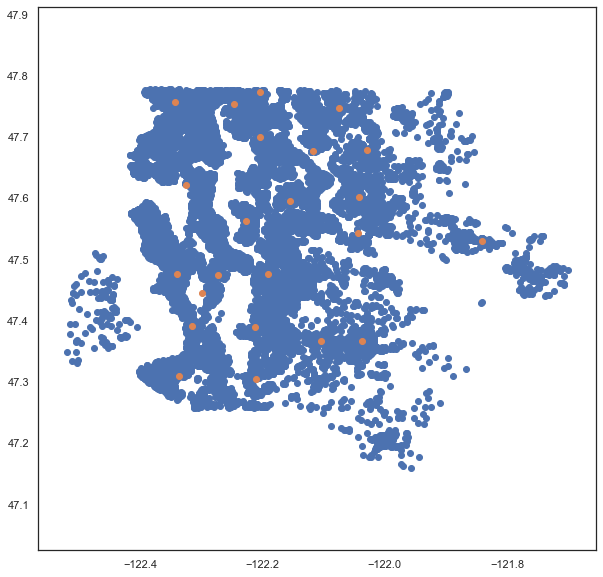

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(x='long',y='lat',data=df_raw[df_raw.long < -121.7])
plt.scatter(x='lng',y='lat',data=city_data)
plt.axis('equal')

#### Get distance to city 

In [83]:
# add coordinats as tuple
df_raw['coord'] = list(zip(df_raw.lat, df_raw.long))
city_data['coord'] = list(zip(city_data.lat, city_data.lng))
df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,coord
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,"(47.5112, -122.257)"
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,"(47.721000000000004, -122.319)"
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,"(47.7379, -122.23299999999999)"
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,"(47.5208, -122.39299999999999)"
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,"(47.6168, -122.045)"


In [84]:
import geopy.distance
def distto(c1, c2):
    return geopy.distance.vincenty(c1, c2).km

for cn in city_data['city']:
    city_coord = city_data[city_data.city == cn].coord
    df_raw[cn] = pd.Series(df_raw.coord.apply(lambda x: distto(x,city_coord)))

/Users/arnescheunemann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  This is separate from the ipykernel package so we can avoid doing imports until


(-122.5658139784946, -121.6541860215054, 47.1223143598234, 47.814585640176595)

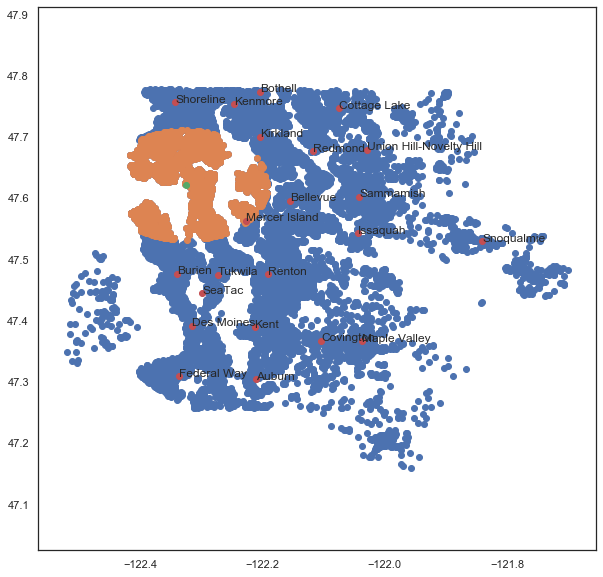

In [37]:
# Verify coordinates
city = 'Seattle'
plt.figure(figsize=(10,10))
plt.scatter(x='long',y='lat',data=df_raw[df_raw.long < -121.7])
plt.scatter(x='long',y='lat',data=df_raw[df_raw[city] < 10])
plt.scatter(x='lng',y='lat',data=city_data[city_data.city == city])
d = city_data[city_data.city != city]
plt.scatter(x='lng',y='lat',data=d[d.city != city])
for c,lat,lng in zip(d.city,d.lat,d.lng):
    plt.text(lng,lat,c, fontsize=12)
plt.axis('equal')

### Unit column adding for EU units m^2

In [86]:
Unit_sqf2sqm = 0.092903
Soccerfield = 68*105

In [87]:
df_raw.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'coord', 'Shoreline',
       'Des Moines', 'Seattle', 'Tukwila', 'Bellevue', 'Cottage Lake', 'Kent',
       'Kenmore', 'Burien', 'Issaquah', 'Kirkland', 'Union Hill-Novelty Hill',
       'Sammamish', 'Auburn', 'Federal Way', 'Bothell', 'Snoqualmie',
       'Mercer Island', 'Renton', 'Covington', 'SeaTac', 'Maple Valley',
       'Redmond'],
      dtype='object')

In [88]:
df_raw['sqm_living'] =  df_raw.sqft_living * Unit_sqf2sqm
df_raw['sqm_lot'] =  df_raw.sqft_lot * Unit_sqf2sqm
df_raw['sqm_lot_soccer'] =  (df_raw.sqft_lot * Unit_sqf2sqm)/Soccerfield
df_raw['sqm_above'] =  df_raw.sqft_above * Unit_sqf2sqm
df_raw['sqm_living15'] =  df_raw.sqft_living15 * Unit_sqf2sqm
df_raw['sqm_lot15'] =  df_raw.sqft_lot15 * Unit_sqf2sqm

### Adding a price in million and thousend doller

In [89]:
df_raw['Mprice'] = df_raw.price/1e6
df_raw['kprice'] = df_raw.price/1e3

### Overall Season of Sales split date of sale 

In [90]:
import re
temp = df_raw['date']
temp = temp.apply(lambda x: int(re.findall('\d+',x)[0]))
df_raw['sale_month'] = temp

In [91]:
import re
temp = df_raw['date']
temp = temp.apply(lambda x: int(re.findall('\d+',x)[2]))
df_raw['sale_year'] = temp
df_raw.sale_year.unique() 
# sales dates are from 2014-2015

array([2014, 2015])

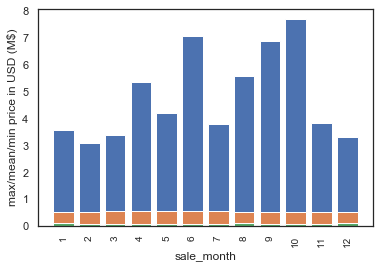

In [92]:
def plotMaxMeanMin(df_p,key,safeto=None):
    keys = [zipcode for zipcode, df in df_p.groupby(['sale_month'])]
    keys = [str(z) for z in keys]
    plt.bar(keys,df_p.groupby(['sale_month']).max()['Mprice'])
    plt.bar(keys,df_p.groupby([key]).mean()['Mprice'])
    plt.bar(keys,df_p.groupby([key]).min()['Mprice'])
    plt.ylabel('max/mean/min price in USD (M$)')
    plt.xlabel(key)
    plt.xticks(keys, rotation='vertical', size=10)
    if safeto:
        plt.savefig(safeto, dpi=300)
    plt.show()
    
plotMaxMeanMin(df_raw,'sale_month','./pic_exports/Sale_Season_Overall_1')

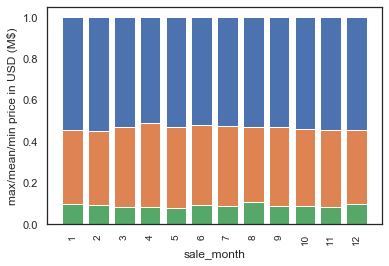

In [93]:
plotMaxMeanMin(df_raw[df_raw.Mprice < 1],'sale_month','./pic_exports/Sale_Season_Overall_2')

### Selecting the rigion

- needed space at least 12000 m^2 for lot
- price limit somwehre ... 

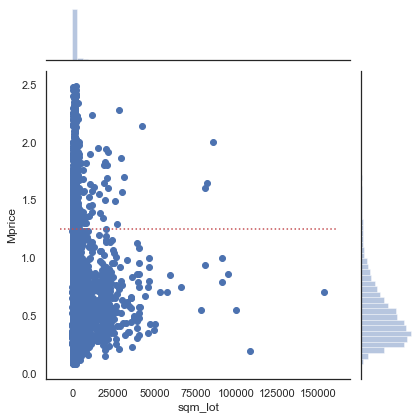

In [102]:
# price limit reasonabel 
g = sns.jointplot(x='sqm_lot',y='Mprice',data=df_raw[df_raw.price < 2.5e6],kind='scatter')
# good box is bellow 

x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
price_limit = 1.25
g.ax_joint.plot([x0,x1], [price_limit,price_limit], ':r')
plt.savefig('./pic_exports/ReasonablePrice', dpi=300)

In [96]:
df_raw.sqm_lot.max()

153416.205177

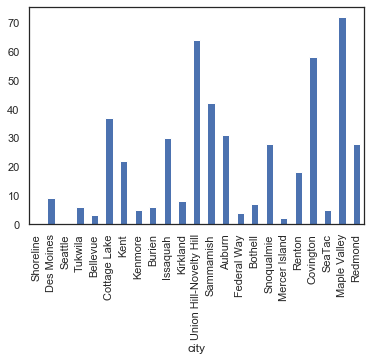

In [105]:
# TODO fill the rest of basic stats
lot_thres = 12000

df_stat = pd.DataFrame(columns=['hits','population','low_price','low_price_lot','mean_lot'], index=city_data.city)
for city in city_data.city:
    df = df_raw[(df_raw[city] < 10) & 
                (df_raw[city] > 2) & 
                (df_raw['sqm_lot'] > lot_thres) & 
                (df_raw['Mprice'] < price_limit)]

    df_stat.at[city,'hits'] = df.shape[0]
    df_stat.at[city,'low_price'] = df.price.min()
    df_stat.at[city,'low_price_lot'] = df[df.price == df.price.min()].sqft_lot.max()
    #print(city)
    a = city_data[city_data.city.str.contains(city)].population.max()
    df_stat.at[city,'population'] = a
    
df_stat.hits.plot.bar()

In [ ]:
### find metric to mage city choice based on availbilty and proximity 

/Users/arnescheunemann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


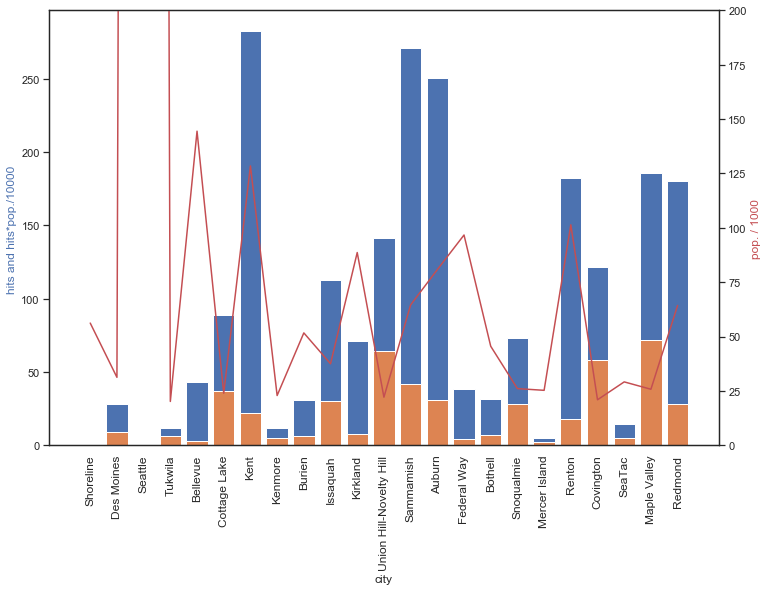

In [109]:
fig, ax1 = plt.subplots(figsize=(12,8))

ax2 = ax1.twinx()
keys = df_stat.index
ax2.plot(keys,df_stat.population/1000,'r')
ax1.bar(keys,df_stat.hits*df_stat.population/10000)
ax1.bar(keys,df_stat.hits*1)
ax1.set_xlabel('city')
ax2.set_ylabel('pop. / 1000', color='r')
ax2.set_ylim([0,200])
ax1.set_ylabel('hits and hits*pop./10000 ', color='b')
ax1.set_xticklabels(keys, rotation='vertical', size=12)
plt.savefig('./pic_exports/CitySelect_Pass2ByHitsWithMetric', dpi=300)
fig.show()

### we continue with top 3 citys Kent,Sammamish, Auburn

In [116]:
city=['Auburn','Kent', 'Sammamish'] 
df_select = df_raw[(((df_raw[city[0]] < 10) & (df_raw[city[0]] > 1)) | 
             ((df_raw[city[1]] < 10) & (df_raw[city[1]] > 1)) |
             ((df_raw[city[2]] < 10) & (df_raw[city[2]] > 1)) ) & 
                (df_raw['sqm_lot'] > lot_thres) & 
                (df_raw['Mprice'] < price_limit)]

df_all_range = df_raw[(((df_raw[city[0]] < 10) & (df_raw[city[0]] > 1)) | 
             ((df_raw[city[1]] < 10) & (df_raw[city[1]] > 1)) |
             ((df_raw[city[2]] < 10) & (df_raw[city[2]] > 1)) )  ]

print(df_select.shape)
print(df_all_range.shape)

(89, 55)
(6037, 55)


(-122.56482831541217, -121.6551716845878, 47.12332613318617, 47.81357386681383)

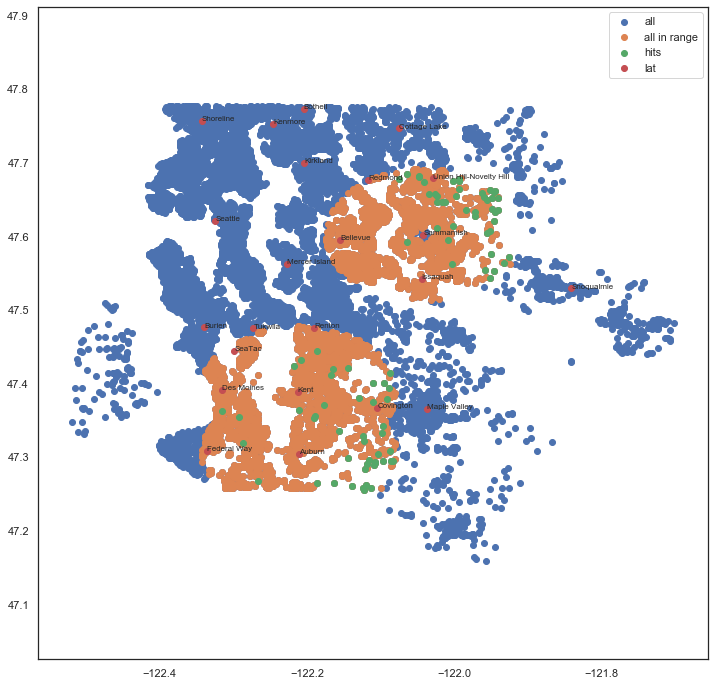

In [119]:
## show selected postion
plt.figure(figsize=(12,12))
plt.scatter(x='long',y='lat',data=df_raw[df_raw.long < -121.7],label= 'all')
plt.scatter(x='long',y='lat',data=df_all_range, label='all in range')
plt.scatter(x='long',y='lat',data=df_select, label='hits')
d = city_data
plt.scatter(x='lng',y='lat',data=d)
for c,lat,lng in zip(d.city,d.lat,d.lng):
    plt.text(lng,lat,c, fontsize=8)
plt.legend()
plt.axis('equal')

### check the price season

In [ ]:
### give feedback about the porp. of finding places 